#### TOLIMAN Pupil Gluing Analysis: Preliminary Measurements

**Aim:**  
To determine:
1. The optical aberrations induced by the lab setup for pupil testing (consisting of 2 OAPs)
2. The intensity distribution ouput from the optical fiber output for later modelling

If we can show these aberrations are static over a long enough period of time (> 30min) then we can confidently remove them from the phase retrieval analysis of the later measurements (glued vs non-glued).

We have chosen to place a spider mask (necessary asymmetry) within the collimated beam to characterise these aberrations via phase retrieval (thank u differentiable modelling/dLux 💖)

In [1]:
import dLux as dl
import dLux.utils as dlu

import jax.numpy as jnp
import numpy as np
import jax.random as jr
import jax.scipy as jsp
from jax import vmap  
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_disable_jit', False)

import zodiax as zdx
import optax
from tqdm.notebook import tqdm

from skimage.io import imread
from skimage.filters import window
import skimage as ski
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 15

In [5]:
# ------- Physical Parameters ---------------------------------------------------------------------#
aperture_npix = 512           # Number of pixels across the aperture
aperture_diameter = 126e-3    # (m)
spider_width = 20e-3          # Spider width (m)
spider_angle =270             # Spider angle (degrees), clockwise, 0 is spider pointing vertically up
coords = dlu.pixel_coords(npixels=aperture_npix, diameter=aperture_diameter)
circle = dlu.circle(coords=coords, radius=aperture_diameter/2) 

# Observations wavelengths (bandpass of 530-640nm)
wavelengths = np.linspace(530e-9, 635e-9, 100)  # Wavelengths to simulate (m)
red_laser_wl =  635e-09  # for laser data
green_laser_wl = 520e-09  # for laser data
wf_npixels = aperture_npix  # Number of pixels across the wavefront
wf_diam = aperture_diameter             # Diameter of initial wavefront to propagate wavefront (m)

# Dtector parameters (BFS-U3-200S6-BD)
BFS_px_sep = 2.4e-6 *1e3        # pixel separation (mm)
f_det = 1300#1350                    # Focal length from OAP2 to detector (mm) 
px_ang_sep = 2*np.arctan( (BFS_px_sep/2)/f_det ) # angular sep between pixels (rad)

# Simulated Detector
psf_npix = 28                 # Number of pixels along one dim of the PSF
psf_hlf_sz = int(psf_npix/2)  
oversample = 1                 # Oversampling factor for the PSF
psf_pixel_scale = dlu.rad2arcsec(px_ang_sep) # arcsec (to match detector plate scale) 80e-4 

# Detector response (gamma curve)
alpha = np.load("data/500us_detector/ALPHA_norm.npy")
beta = np.load("data/500us_detector/BETA_norm.npy")
gamma = np.load("data/500us_detector/GAMMA_norm.npy")

#### Load in some ✨real✨ data 🌈
- Check intensity distribution across pupil first


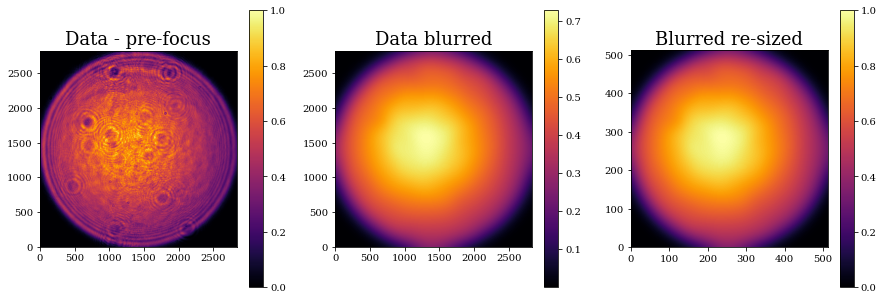

In [3]:
fname = "data/intensity/15_07_intensity_dist.png"
data = imread(fname, as_gray=True) 
manual_lim = [1363,4203,386,3214]
data = data[manual_lim[2]:manual_lim[3], manual_lim[0]:manual_lim[1]]
data = (data - data.min())/(data.max()-data.min())

blurred = ski.filters.gaussian(data, sigma=(120, 120))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(data)
plt.title("Data - pre-focus")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(blurred)
plt.title("Data blurred")
plt.colorbar()
plt.subplot(1,3,3)
intensity_dist = resize(blurred, (aperture_npix, aperture_npix))
intensity_dist = (intensity_dist - intensity_dist.min())/(intensity_dist.max()-intensity_dist.min()) # re-map from 0-1
# intensity_dist = np.fliplr(intensity_dist)
# intensity_dist = np.flip(intensity_dist)
plt.title("Blurred re-sized")
plt.imshow(intensity_dist)
plt.colorbar()


In [ ]:
# Create dLux class for this gauss transmissive layer
# maybe modelling a source object would be easier?
class GaussTransmissiveLayer(dl.layers.optical_layers.TransmissiveLayer):
    """
        Inherits from dl.layers.TransmissiveLayer and allows for
        a Gaussian transmissive layer to be simulated. Useful for 
        simulating a wavefront that is not uniform in intensity.

        Attributes
        ----------
        transmission: Array
            The Array of transmission values to be applied to the input wavefront.
        gaussian_param: Array = [var_x, var_y], shape (2,)
            The parameters defining the 2D Gaussian to be applied to the input wavefront.
            Where:
            var_x, var_y = float
                Variance in the x and y directions (m)
            Center of Gaussian is given by position of Pointsource
        pixel_coords : Array
            3D array of pixel coordinates over which gaussian is defined in the shape
            (2, npix, npix) where npix is the number of pixels across one dimension of the
            each 2D array (one for X and Y).
        det_npix: int
            Number of pixels across the detector.
        psf_pixel_scale: float
            Pixel scale of the detector (arcsec/px).
        normalise: bool
            Whether to normalise the wavefront after passing through the optic.
    """
    X: jnp.array
    Y: jnp.array

    gauss_param: jnp.array
    point_source: dl.PointSources
    det_npix: int
    pp_npix: int # pupil-plane pixel size
    psf_pixel_scale: float
    pixel_size: float

    def __init__(
        self: dl.layers.optical_layers.OpticalLayer,
        point_source: dl.PointSources,
        gaussian_param: jnp.array,
        pixel_coords: jnp.array,
        det_npix: int,
        psf_pixel_scale: float,
        normalise: bool = False,
    ):
        self.X, self.Y = pixel_coords
        assert gaussian_param.shape == (2,), "Gaussian parameters must be of shape (2,) in form [var_x, var_y] "
        self.pp_npix = self.X.shape[0]
        self.gauss_param = gaussian_param
        self.point_source = point_source

        self.det_npix = det_npix
        self.psf_pixel_scale = psf_pixel_scale
        self.pixel_size = jnp.abs(pixel_coords[0,0,1] - pixel_coords[0,0,0]) #distance between adjacent px

        trans = self.get_transmission()

        super().__init__(transmission=trans, normalise=normalise)

    def get_transmission(self):
        # angular position to number of pixels across detector
        pos = self.point_source.position[0]
        x_0_px = dlu.rad2arcsec(pos[0]) / self.psf_pixel_scale 
        y_0_px = dlu.rad2arcsec(pos[1]) / self.psf_pixel_scale 

        # convert to number of pixels across pupil plane
        x_0_px *= self.pp_npix / self.det_npix
        y_0_px *= self.pp_npix / self.det_npix 

        # convert to linear distance (m) across pupil plane
        x_0 = x_0_px*self.pixel_size
        y_0 = y_0_px*self.pixel_size

        # x_0 *= -1 #dLux conventions or Positon
        # y_0 *= -1

        z = jnp.exp(-(self.X - x_0)**2/(2*self.gauss_param[0]**2) - (self.Y - y_0)**2/(2*self.gauss_param[1]**2))

        return z 

    def apply(self: dl.layers.optical_layers.OpticalLayer, wavefront: dl.wavefronts.Wavefront) -> dl.wavefronts.Wavefront:
        """
        Applies the layer to the wavefront.

        Parameters
        ----------
        wavefront : Wavefront
            The wavefront to operate on.

        Returns
        -------
        wavefront : Wavefront
            The transformed wavefront.
        """
        wavefront *= self.get_transmission()
        if self.normalise:
            wavefront = wavefront.normalise()
        return wavefront


In [ ]:
# Define non-linear detector response
class ApplyBFSPixelResponse(dl.layers.detector_layers.DetectorLayer):
    """
    Applies a pixel response array to the input psf, via a multiplication. This can be
    used to model variations in the inter and intra-pixel sensitivity variations common
    to most detectors.

    We have characterised the BFS detector to have a gamma curve gain response per px.

    ??? abstract "UML"
        ![UML](../../assets/uml/ApplyPixelResponse.png)

    Attributes
    ----------
    pixel_response : Array
        The pixel_response to apply to the input psf in the form of gamma fn coeffs:
        measured_intensity = alpha + beta*real_intensity^gamma
        with    pixel_response[0] = alpha
                pixel_response[1] = beta
                pixel_response[2] = gamma
    luminance_min, luminance_max : float
        The minimum and maximum input luminance values for the pixel response (with which the 
        gamma curve was characterised).
    intensity_min, intensity_max : float
        The minimum and maximum output intensity values for the pixel response (with which the 
        gamma curve was characterised).
    """

    pixel_response: jnp.array
    x_intercepts: jnp.array
    # luminance_min: float
    # luminance_max: float
    # intensity_min: float
    # intensity_max: jnp.float64

    def __init__(self: dl.layers.detector_layers.DetectorLayer, 
                 pixel_response: jnp.array,
                # luminance_min: float,
                # luminance_max: float,
                # intensity_min: float,
                # intensity_max: float,
                 ):
        """
        Parameters
        ----------
        pixel_response : Array
            The pixel_response to apply to the input psf. Must be a 2-dimensional array
            equal to size of the psf at time of application.
        """
        super().__init__()
        # assert pixel_response.shape[0] == 3, "Pixel response must contain 3 matrices corresponding to gamma fn coeffs"
        # assert luminance_max > luminance_min, "luminance_max must be greater than luminance_min"
        # assert intensity_max > intensity_min, "intensity_max must be greater than intensity_min"

        self.pixel_response = jnp.asarray(pixel_response, dtype=float)
        self.x_intercepts = self.calc_x_intercepts()
        # self.luminance_min = jnp.array(luminance_min, dtype=float)
        # self.luminance_max = jnp.array(luminance_max, dtype=float)
        # self.intensity_min = jnp.array(intensity_min, dtype=float)
        # self.intensity_max = jnp.array(intensity_max, dtype=float)

    def calc_x_intercepts(self):
        """
            Calculate the x-intercepts of the gamma function, for input intensity values
            that result in curve below x-axis. Think this is just a precision artefact.
        """
        x_int = jnp.power((-self.pixel_response[0] / self.pixel_response[1]), 1/self.pixel_response[2])
        
        return x_int


    def apply(self: dl.layers.detector_layers.DetectorLayer, psf: dl.PSF) -> dl.PSF:
        """
        Applies the layer to the PSF.

        Parameters
        ----------
        psf : PSF
            The psf to operate on.

        Returns
        -------
        psf : PSF
            The transformed psf.

        """
        psf_array = jnp.asarray(psf.data, dtype=float)
        # # assert psf_array.shape == self.pixel_response[0].shape and\
        # # psf_array.shape == self.pixel_response[1].shape and \
        # # psf_array.shape == self.pixel_response[2].shape, "PSF and pixel response must have same shape"

        # # remap to [luminance_min, luminance_max] for measured gamma fn 
        # orig_min, orig_max = psf_array.min(), psf_array.max()
        # # print(orig_min, orig_max)
        # # data_remapped = psf_array #0.0 + ((1.0 - 0.0)/(orig_max-orig_min))*(psf_array - orig_min)

        # # # t1 = jnp.isnan(orig_max-orig_min)
        # # # t2 = jnp.isnan(psf_array - orig_min)
        # # # print(t1.sum(), t2.sum())
        # # # print("data remapped max and min:", data_remapped.max(), data_remapped.min())

        # power = psf_array**self.pixel_response[2] # think jnp.power() is causing nan grads
        # measured_psf = self.pixel_response[0] + self.pixel_response[1]*power #element-wise power

        # # neg_mask = measured_psf < 0.0
        # # measured_psf = measured_psf*jnp.invert(neg_mask) + psf_array*neg_mask # take orig values if neg


        # # print("coeffs: {}, {},{}, input intensity: {} output intensity: {}".format(self.pixel_response[0][0,0],self.pixel_response[1][0,0],self.pixel_response[2][0,0], psf_array[0,0], measured_psf[0,0]))
        
        # # # for some reason this is not guaranteed to be in the range of [intensity_min, intensity_max]?? fns calc should be in range
        # # # either interpet this as 0 pixel or remap range? 
        # # Because of floating point precision limitations - very small values show curve below x-axis. Remap to fix this.
        # measured_psf = orig_min+ ((1.0 - orig_min)/(measured_psf.max()-measured_psf.min()))*(measured_psf - measured_psf.min())
        # # # print(measured_psf.max(), measured_psf.min())

        # # # print(self.pixel_response[0][0,0],self.pixel_response[1][0,0],self.pixel_response[2][0,0])
        # # # reamap back to original range (in range of [intensity_min, intensity_max] currently)
        # # measured_psf = orig_min + ((orig_max - orig_min)/(1.0 - 0.0))*(measured_psf - 0.0)

        # # # psf_obj = dl.PSF(data = data_remapped, pixel_scale = psf.pixel_scale)
        # # measured_psf = measured_psf.at[measured_psf < 0.0].set(0.0001)
        # # psf_obj = dl.PSF(data = jnp.abs(measured_psf), pixel_scale = psf.pixel_scale)
        # psf_obj = dl.PSF(data = (measured_psf), pixel_scale = psf.pixel_scale)


        psf_obj = dl.PSF(data = psf_array**(1/1), pixel_scale = psf.pixel_scale)


        return psf_obj


In [41]:
# Zernike aberrations
zernike_indicies = jnp.arange(4, 15) # up to 10th noll idxs (excluding piston)
coeffs = jnp.zeros(zernike_indicies.shape)
basis = dlu.zernike_basis(js=zernike_indicies, coordinates=coords, diameter=aperture_diameter)

# Using PointSources instead of single PointSource object to overcome float grad issue when solving for flux
# https://github.com/LouisDesdoigts/dLux/issues/271 
# src = dl.PointSources(wavelengths=[laser_wavelength], flux =jnp.asarray([1e8],dtype=float))


spider_angles = [270, 180] #deg is spider pointing vertically up, rotates CW from 0deg
optical_systems = []
transmissions = []
green_src = dl.PointSources(wavelengths=[green_laser_wl], flux =jnp.asarray([1e8],dtype=float))
red_src = dl.PointSources(wavelengths=[red_laser_wl], flux =jnp.asarray([1e8],dtype=float))

for i in range(len(spider_angles)):
    spider = dlu.spider(coords=coords, width=spider_width, angles=[spider_angles[i]])
    transmission = dlu.combine([circle, spider])*intensity_dist

    layers = [
        ('aperture', dl.layers.BasisOptic(basis, transmission, coeffs, normalise=False)),
    ]

    optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)

    optical_systems.append(optics)
    transmissions.append(transmission)

# Construct Optics
optics_sp270  = optical_systems[0]
optics_sp180 = optical_systems[1]
sp270_trans = transmissions[0]
sp180_trans = transmissions[1]
# ----------------------------------------------------------------------------------#
# # Create detector layer to characterise non-linear response of BFS det 
# row_start, col_start = 1676, 2532 # Start coord of window on det where data was taken
# row_len, col_len = 86, 76   # window size of recorded data
# psf_hlf_sz = 14             # half window sz of cropped data

# # load in response curve matrices (form of Gamma fn)
# alpha = np.load("data/80us_detector/ALPHA_norm.npy")[row_start:row_start+row_len, col_start:col_start+col_len]
# beta = np.load("data/80us_detector/BETA_norm.npy")[row_start:row_start+row_len, col_start:col_start+col_len]
# gamma = np.load("data/80us_detector/GAMMA_norm.npy")[row_start:row_start+row_len, col_start:col_start+col_len]

# # Crop, anchored on middle (cropped data will be based on max values, but this occurs close enough to the
# # middle to estimate here. + detector response is fairly homogenous over small window)
# middle_row, middle_col = int(alpha.shape[0]/2), int(alpha.shape[1]/2)
# cropped_alpha = alpha[middle_row-psf_hlf_sz:middle_row+psf_hlf_sz, middle_col-psf_hlf_sz:middle_col+psf_hlf_sz]
# cropped_beta = beta[middle_row-psf_hlf_sz:middle_row+psf_hlf_sz, middle_col-psf_hlf_sz:middle_col+psf_hlf_sz]
# cropped_gamma = gamma[middle_row-psf_hlf_sz:middle_row+psf_hlf_sz, middle_col-psf_hlf_sz:middle_col+psf_hlf_sz]

# pixel_response = jnp.array([cropped_alpha, cropped_beta, cropped_gamma])
# detector = dl.LayeredDetector([ApplyBFSPixelResponse(pixel_response=pixel_response)])


Loss fn's

In [21]:
params = [
    'aperture.coefficients',
    'source.position',
    'source.flux', 
    ]
optimisers = [
            optax.adam(learning_rate=1e-9),
            optax.adam(learning_rate=1e-9),
            optax.adam(learning_rate=1e6),
              ]
@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_gaussian(model, data):

    simu_psf = model.model()

    uncertainty = 0.1 # 10% err per pix TODO try increasing

    loss = -jsp.stats.norm.logpdf(x=simu_psf, loc=data, scale=data*uncertainty).sum()

    return loss
@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_poisson(model, data):

    simu_psf = model.model()

    loss = -jsp.stats.poisson.logpmf(k=simu_psf, mu=data).sum()

    return loss

Lets loop this

Starphire 1 

In [37]:
# Location on detector 
row_start, col_start = 1676, 2600 # Start coord of window on det where data was taken
row_len, col_len = 86, 76   # window size of recorded data

alpha_cropped = alpha[row_start:row_start+row_len, col_start:col_start+col_len]
beta_cropped = beta[row_start:row_start+row_len, col_start:col_start+col_len]
gamma_cropped = gamma[row_start:row_start+row_len, col_start:col_start+col_len]

img_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_green_0deg_294us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_green_90deg_294us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_red_0deg_133us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_red_90deg_200us_0gain_img_stack_batch_0.npy",
    
]
labels = [
    "0deg_green",
    "90deg_green",
    "0deg_red",
    "90deg_red",
]
bckgnd_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_green_0deg_bckgnd_294us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_green_90deg_bckgnd_294us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_green_0deg_bckgnd_294us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire1_green_90deg_bckgnd_294us_0gain_img_stack_batch_0.npy",
]
still_frame_idxs = [
    151, 163, 84, 113 # find_still_frame.py
]

epochs = [
    5000, 5000,5000,5000,
]

Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimised Position: [[1.51015408e-06 1.98813413e-06]]
Flux: [2.27726377e+08]
Coefficients: [ 2.11182964e-08  5.92054732e-08 -1.17545186e-07 -9.60835738e-09
  2.86687607e-09 -4.13539014e-09  5.15762509e-09  1.12154892e-09
  1.81111382e-08 -6.10961717e-09  1.91648474e-08]


Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimised Position: [[1.07323933e-06 6.94761608e-07]]
Flux: [2.79848661e+08]
Coefficients: [ 6.32601330e-08 -2.41386191e-08 -3.14442058e-08  1.80741188e-10
 -1.16503553e-08 -4.19022992e-09  8.57949460e-09 -3.67080462e-08
  6.59378351e-09 -3.12733843e-09  1.35677999e-08]


Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimised Position: [[2.01132876e-06 2.04972603e-06]]
Flux: [1.5539884e+08]
Coefficients: [ 5.20795959e-08 -2.25312785e-08 -2.43482104e-08 -1.25203698e-08
 -9.18626960e-09  2.20385440e-09  1.98997686e-08 -3.23329452e-08
  6.94888186e-09 -3.14836388e-10  7.21425053e-09]


Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimised Position: [[1.26641825e-06 6.49277566e-07]]
Flux: [1.45582578e+08]
Coefficients: [ 5.47513376e-08 -1.92128377e-08 -3.54366184e-08  5.97985907e-09
 -1.14639105e-08 -3.84361954e-09  5.61212402e-09 -2.81076279e-08
  1.03900585e-08  3.86839510e-09  4.88831832e-10]


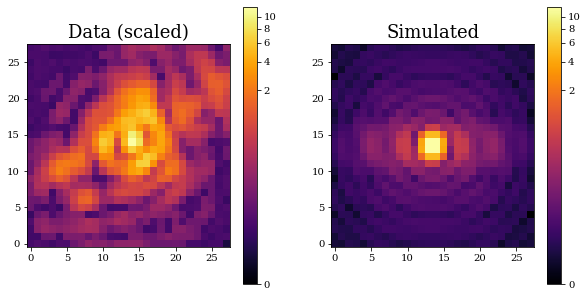

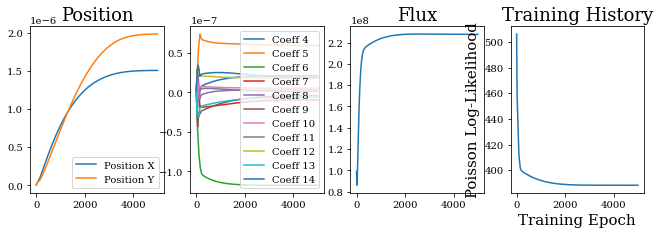

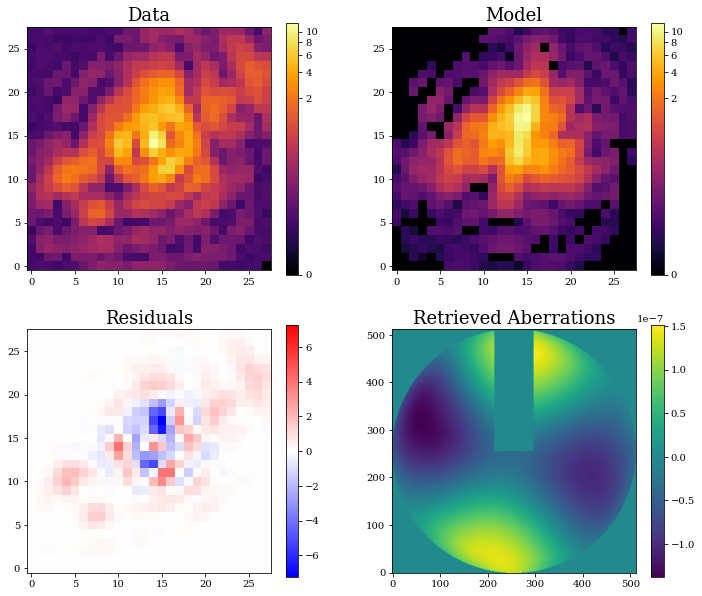

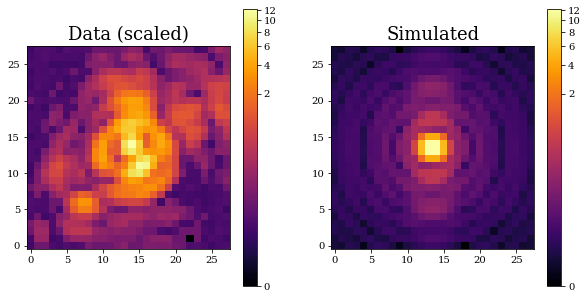

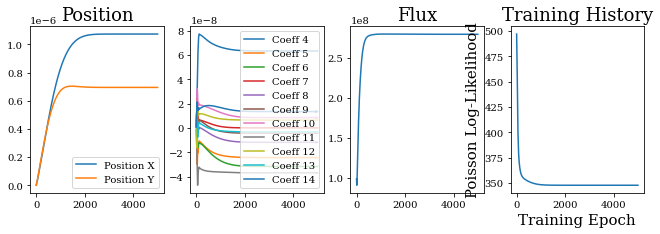

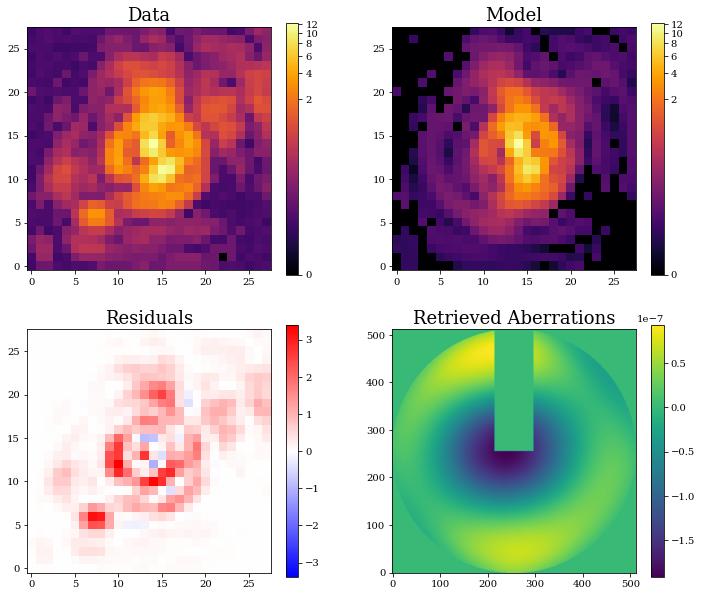

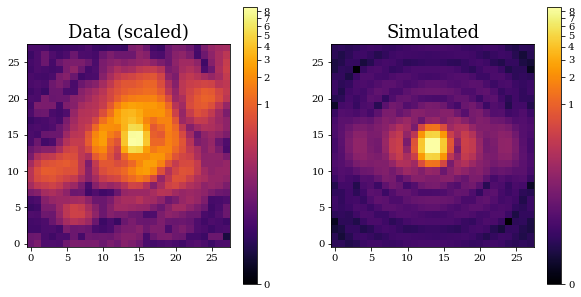

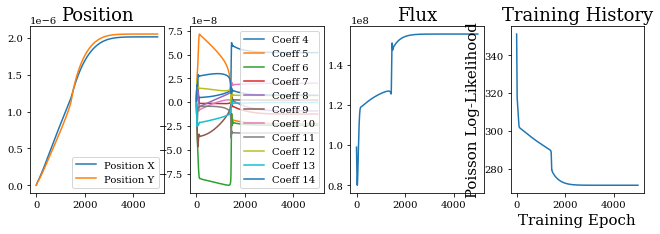

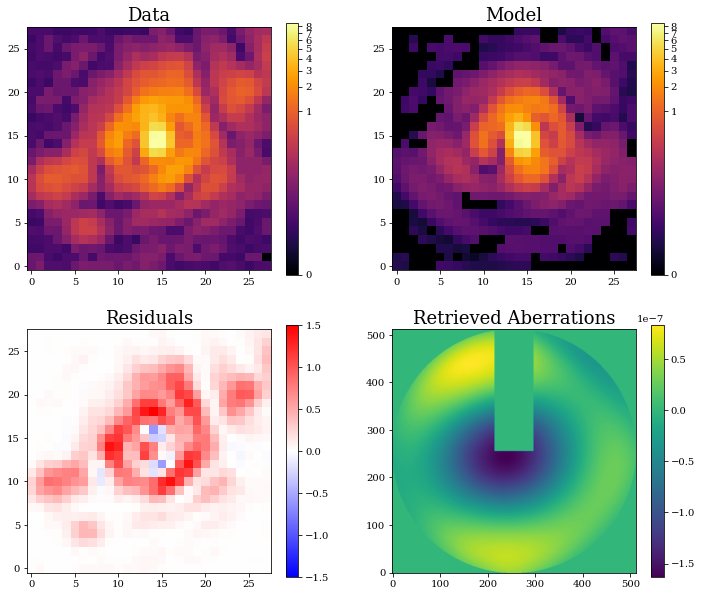

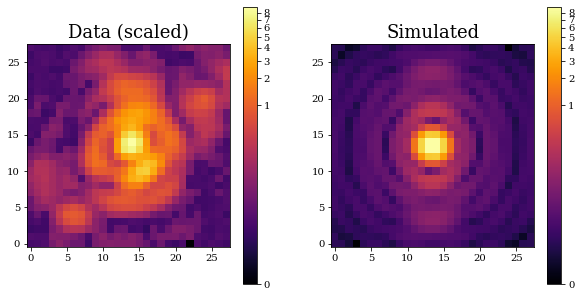

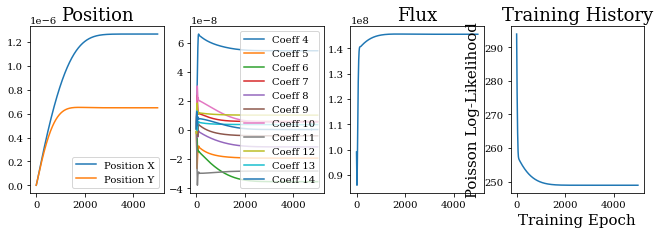

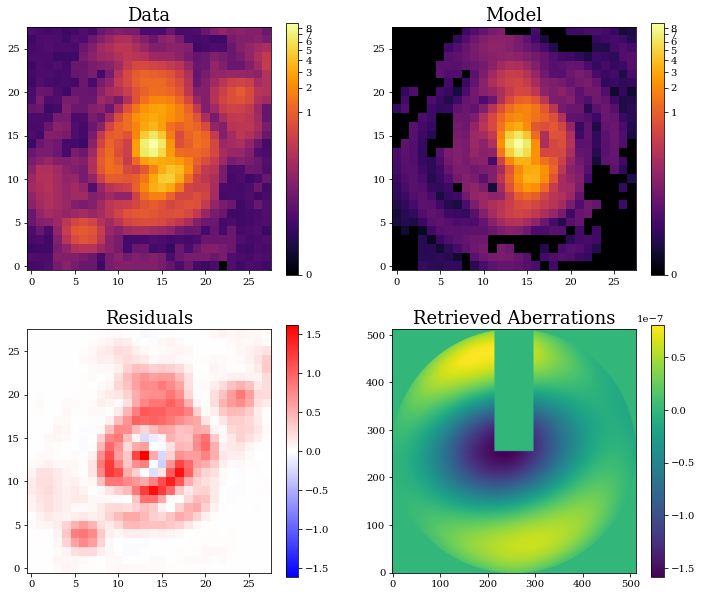

In [38]:
starphire1_coeffs, starphire1_pos = [], []

# no error bars, individual orientation fitting TODO sems all frames - not sure how to do simulatenous opt with mult images
for i in range(len(img_fnames)):
    ###---------------------------- Re-init model ----------------------------###
    if '_0deg_' in img_fnames[i]:
        optics = optics_sp180
        transmission = sp180_trans
    elif '_90deg_' in img_fnames[i]:
        optics = optics_sp270
        transmission= sp270_trans
    else:
        ValueError("Unknown File format")

    if 'green' in img_fnames[i]:
        src = green_src
    elif 'red' in img_fnames[i]:
        src = red_src
    else:
        ValueError("Unknown File format")

    instrument = dl.Telescope(optics, ('source', src))
    sim_psf = instrument.model()
    norm_psf = PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min())

    ###------------------------------- Load data -----------------------------###
    data = np.load(img_fnames[i])
    data = data[still_frame_idxs[i],:,:] # using the most still frame (find_still_frame.py)

    bckgnd = np.load(bckgnd_fnames[i])
    bckgnd = np.mean(bckgnd)
    data = data - bckgnd

    data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
    data_lin = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # flip about origin

    # Scale intensity
    data = data_lin
    current_range = data.max() - data.min()
    new_range = sim_psf.max() - sim_psf.min()
    scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

    psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
    scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(scaled_data, norm=norm_psf)
    plt.colorbar()
    plt.title("Data (scaled)")
    plt.subplot(1,2,2)
    plt.imshow(sim_psf, norm=norm_psf)
    plt.colorbar()
    plt.title("Simulated")

    ###------------------------------- Phase Retrieval -----------------------------###
    optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

    progress_bar = tqdm(range(epochs[i]), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions, Fluxes= [],[],[],[]
    for j in progress_bar:
        poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

        updates, opt_state = optim.update(poiss_grads, opt_state)
        instrument = zdx.apply_updates(instrument, updates) 

        net_losses.append(poiss_loss)
        Fluxes.append(instrument.source.flux)
        Coeffs.append(instrument.aperture.coefficients)
        Positions.append(instrument.source.position)

        progress_bar.set_postfix({'Loss': poiss_loss})
    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(11,3))
    plt.subplot(1,4,1)
    plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
    plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
    plt.title("Position")
    plt.legend()
    plt.subplot(1,4,2)
    arr_coeffs = np.asarray(Coeffs)
    for k in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[k])
        plt.plot(arr_coeffs[:,k], label=label)
    plt.legend()
    plt.subplot(1,4,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(1,4,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")


    plt.figure(figsize=(12,10))
    norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
    plt.subplot(2,2,1)
    plt.imshow(scaled_data, norm=norm_psf)
    plt.colorbar()
    plt.title('Data')

    plt.subplot(2,2,2)
    model_psf = instrument.model()
    current_range = model_psf.max() - model_psf.min()
    new_range = scaled_data.max() - scaled_data.min()
    model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
    norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
    mask = np.ones(scaled_data.shape)
    mask[scaled_data < 0.01] = 0
    plt.imshow(model_psf*mask, norm=norm_psf)
    plt.title('Model')
    plt.colorbar()

    plt.subplot(2,2,3)
    resid = scaled_data - model_psf
    plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
    plt.colorbar()
    plt.title('Residuals')

    plt.subplot(2,2,4)
    opd = instrument.aperture.eval_basis()
    plt.imshow(opd*transmission, cmap='viridis')
    plt.title('Retrieved Aberrations')
    plt.colorbar()


    print("Optimised Position: {}\nFlux: {}\nCoefficients: {}".format(instrument.source.position, instrument.source.flux, instrument.aperture.coefficients))

    starphire1_coeffs.append(instrument.aperture.coefficients)
    starphire1_pos.append(instrument.source.position)


0deg_green RMS WFE: 0.263lambda
90deg_green RMS WFE: 0.175lambda
0deg_red RMS WFE: 0.118lambda
90deg_red RMS WFE: 0.125lambda
Mean RMS WFE: 0.170lambda


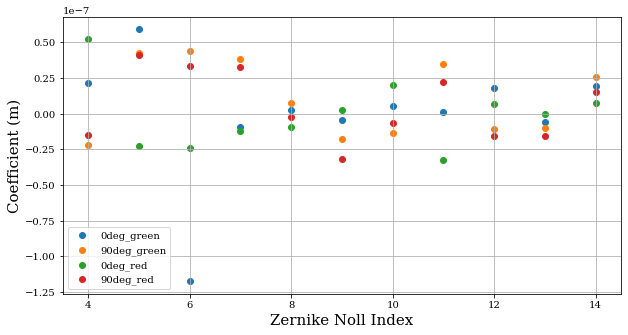

In [35]:
# Plot 
# WFE calc excluding piston, tip and tilt
plt.figure(figsize=(10,5))
wf_errs = []
for i,coeffs in enumerate(starphire1_coeffs):
    plt.scatter(zernike_indicies, coeffs, label=labels[i])
    RMS_wf_err = ((coeffs**2).sum())**0.5

    if 'red' in labels[i]:
        wl = red_laser_wl
    elif 'green' in labels[i]:
        wl = green_laser_wl
    else:
        ValueError("Unknown Wavelength")

    print("{} RMS WFE: {:.3f}lambda".format(labels[i], RMS_wf_err/wl))
    wf_errs.append(RMS_wf_err/wl) 

plt.xlabel("Zernike Noll Index")
plt.ylabel("Coefficient (m)")
plt.grid()
plt.legend()

print("Mean RMS WFE: {:.3f}lambda".format(np.mean(wf_errs)))

Starphire 2

In [42]:
img_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire2_green_0deg_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire2_green_90deg_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire2_red_0deg_120us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire2_red_90deg_80us_0gain_img_stack_batch_0.npy",
    
]
labels = [
    "0deg_green",
    "90deg_green",
    "0deg_red",
    "90deg_red",
]
bckgnd_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire2_green_0deg_bckgnd_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire2_green_90deg_bckgnd_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire2_green_0deg_bckgnd_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/5_09_starphire2_green_90deg_bckgnd_80us_0gain_img_stack_batch_0.npy",
]
still_frame_idxs = [
    151, 163, 84, 113 # find_still_frame.py
]

epochs = [
    5000, 5000,5000,5000,
]

Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimised Position: [[8.49417562e-07 4.39673919e-07]]
Flux: [1.55994706e+08]
Coefficients: [-1.12753204e-08 -5.54970831e-09 -3.99666906e-08  2.37163730e-09
 -4.12482744e-08  1.29571230e-08 -3.21861537e-08 -1.02541294e-10
  1.48484053e-08  5.11130327e-09  2.23692376e-08]


Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimised Position: [[1.25285571e-06 1.01461091e-06]]
Flux: [1.13770193e+08]
Coefficients: [-9.11976614e-09 -1.15469417e-08 -3.33592022e-08  1.06852301e-08
 -3.71626328e-08  1.48608535e-08 -2.69671015e-08 -9.40349467e-09
  4.31959648e-09  8.62154757e-09  1.37395041e-08]


Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimised Position: [[1.35102167e-06 2.66936644e-07]]
Flux: [89103627.54355432]
Coefficients: [-1.45590918e-08  6.99288952e-10 -2.76418099e-08  1.50753313e-09
 -3.36109484e-08  1.26303341e-08 -2.85060730e-08 -1.78115599e-09
  4.14982186e-09  3.12563078e-10  7.29764075e-09]


Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimised Position: [[7.09735576e-07 1.71545064e-06]]
Flux: [80918336.95294233]
Coefficients: [-1.59019030e-08 -4.31468918e-09 -2.72802368e-08  6.86289862e-09
 -1.88630960e-08  4.89126368e-09 -1.23868714e-08 -3.49208034e-09
  3.58857243e-09  2.60586401e-09  6.90307480e-09]


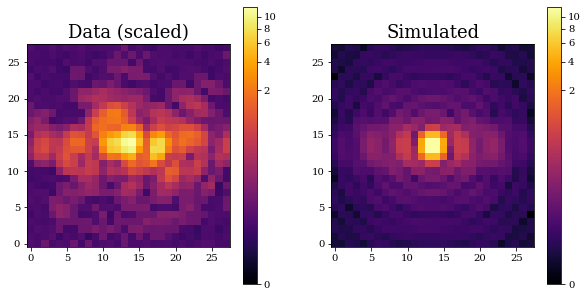

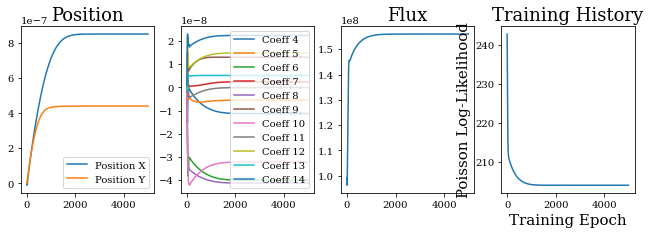

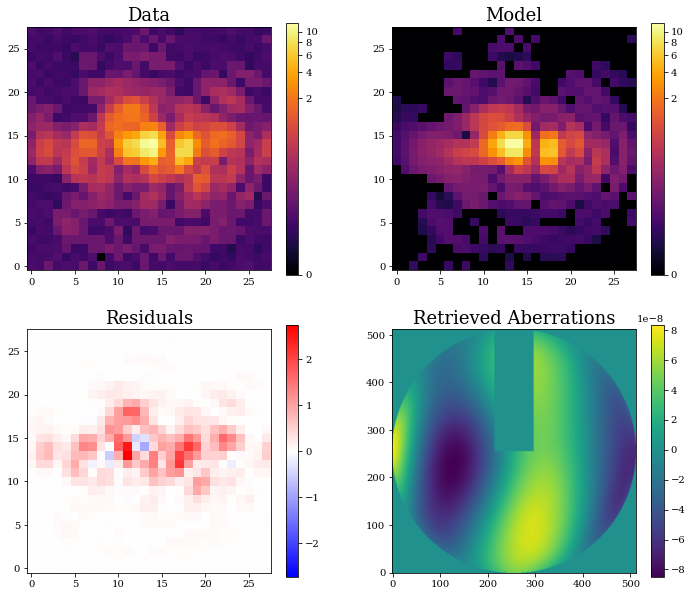

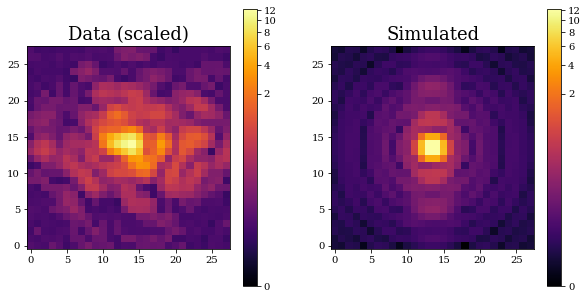

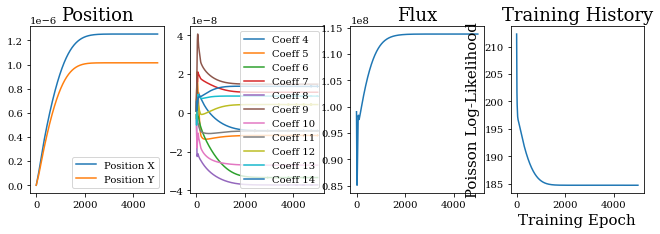

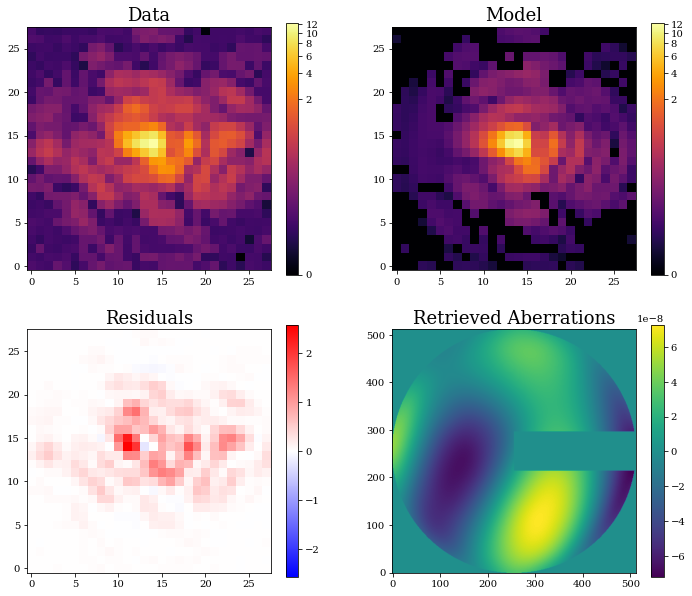

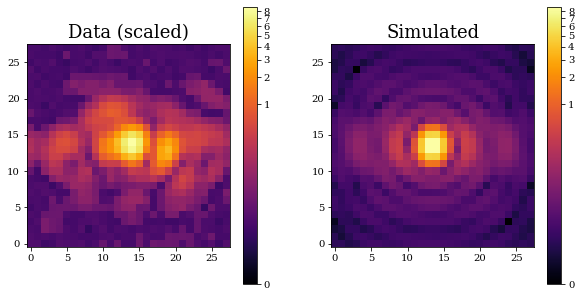

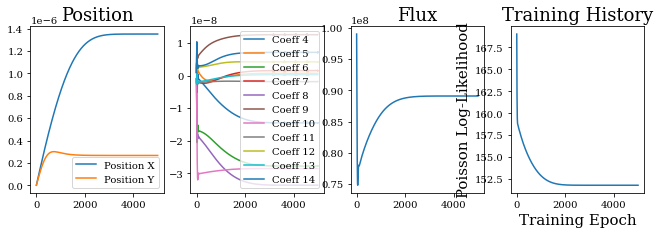

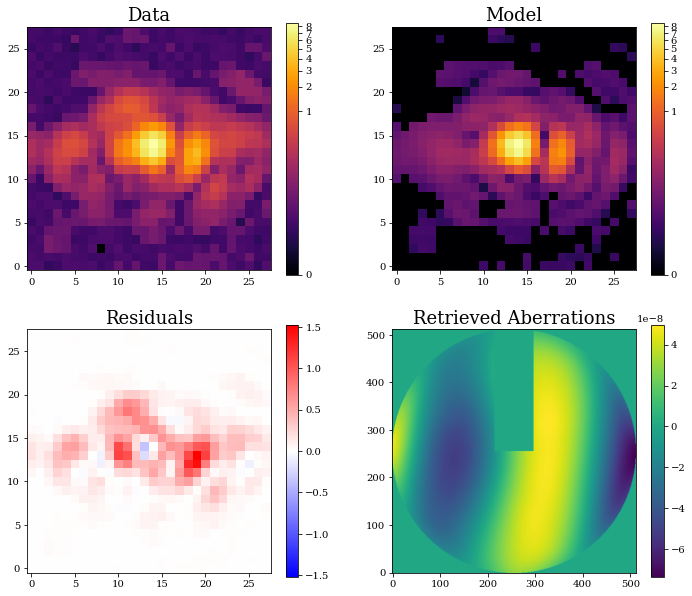

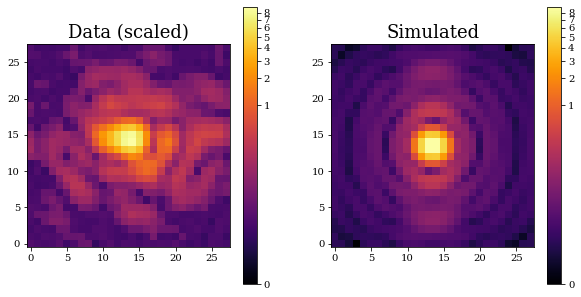

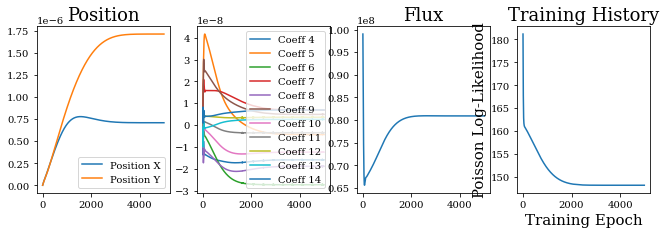

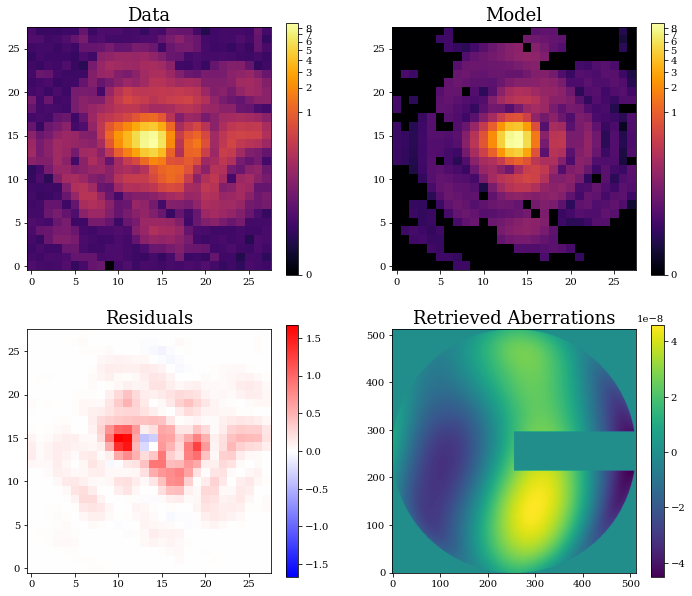

In [43]:
starphire2_coeffs, starphire2_pos = [], []

# no error bars, individual orientation fitting TODO sems all frames - not sure how to do simulatenous opt with mult images
for i in range(len(img_fnames)):
    ###---------------------------- Re-init model ----------------------------###
    if '_0deg_' in img_fnames[i]:
        optics = optics_sp180
        transmission = sp180_trans
    elif '_90deg_' in img_fnames[i]:
        optics = optics_sp270
        transmission= sp270_trans
    else:
        ValueError("Unknown File format")

    if 'green' in img_fnames[i]:
        src = green_src
    elif 'red' in img_fnames[i]:
        src = red_src
    else:
        ValueError("Unknown File format")

    instrument = dl.Telescope(optics, ('source', src))
    sim_psf = instrument.model()
    norm_psf = PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min())

    ###------------------------------- Load data -----------------------------###
    data = np.load(img_fnames[i])
    data = data[still_frame_idxs[i],:,:] # using the most still frame (find_still_frame.py)

    bckgnd = np.load(bckgnd_fnames[i])
    bckgnd = np.mean(bckgnd)
    data = data - bckgnd

    data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
    data_lin = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # flip about origin

    # Scale intensity
    data = data_lin
    current_range = data.max() - data.min()
    new_range = sim_psf.max() - sim_psf.min()
    scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

    psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
    scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(scaled_data, norm=norm_psf)
    plt.colorbar()
    plt.title("Data (scaled)")
    plt.subplot(1,2,2)
    plt.imshow(sim_psf, norm=norm_psf)
    plt.colorbar()
    plt.title("Simulated")

    ###------------------------------- Phase Retrieval -----------------------------###
    optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

    progress_bar = tqdm(range(epochs[i]), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions, Fluxes= [],[],[],[]
    for j in progress_bar:
        poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

        updates, opt_state = optim.update(poiss_grads, opt_state)
        instrument = zdx.apply_updates(instrument, updates) 

        net_losses.append(poiss_loss)
        Fluxes.append(instrument.source.flux)
        Coeffs.append(instrument.aperture.coefficients)
        Positions.append(instrument.source.position)

        progress_bar.set_postfix({'Loss': poiss_loss})
    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(11,3))
    plt.subplot(1,4,1)
    plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
    plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
    plt.title("Position")
    plt.legend()
    plt.subplot(1,4,2)
    arr_coeffs = np.asarray(Coeffs)
    for k in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[k])
        plt.plot(arr_coeffs[:,k], label=label)
    plt.legend()
    plt.subplot(1,4,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(1,4,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")


    plt.figure(figsize=(12,10))
    norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
    plt.subplot(2,2,1)
    plt.imshow(scaled_data, norm=norm_psf)
    plt.colorbar()
    plt.title('Data')

    plt.subplot(2,2,2)
    model_psf = instrument.model()
    current_range = model_psf.max() - model_psf.min()
    new_range = scaled_data.max() - scaled_data.min()
    model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
    norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
    mask = np.ones(scaled_data.shape)
    mask[scaled_data < 0.01] = 0
    plt.imshow(model_psf*mask, norm=norm_psf)
    plt.title('Model')
    plt.colorbar()

    plt.subplot(2,2,3)
    resid = scaled_data - model_psf
    plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
    plt.colorbar()
    plt.title('Residuals')

    plt.subplot(2,2,4)
    opd = instrument.aperture.eval_basis()
    plt.imshow(opd*transmission, cmap='viridis')
    plt.title('Retrieved Aberrations')
    plt.colorbar()


    print("Optimised Position: {}\nFlux: {}\nCoefficients: {}".format(instrument.source.position, instrument.source.flux, instrument.aperture.coefficients))

    starphire2_coeffs.append(instrument.aperture.coefficients)
    starphire2_pos.append(instrument.source.position)


0deg_green RMS WFE: 0.141lambda
90deg_green RMS WFE: 0.124lambda
0deg_red RMS WFE: 0.088lambda
90deg_red RMS WFE: 0.064lambda
Mean RMS WFE: 0.105lambda


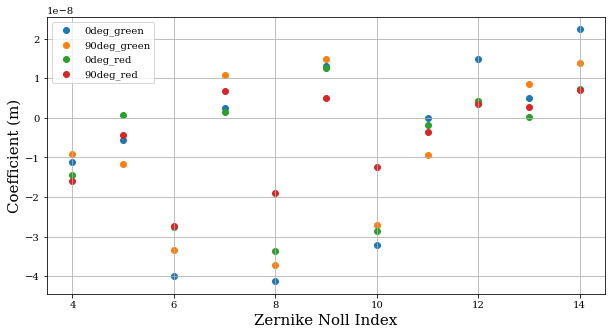

In [44]:
# Plot 
# WFE calc excluding piston, tip and tilt
plt.figure(figsize=(10,5))
wf_errs = []
for i,coeffs in enumerate(starphire2_coeffs):
    plt.scatter(zernike_indicies, coeffs, label=labels[i])
    RMS_wf_err = ((coeffs**2).sum())**0.5

    if 'red' in labels[i]:
        wl = red_laser_wl
    elif 'green' in labels[i]:
        wl = green_laser_wl
    else:
        ValueError("Unknown Wavelength")

    print("{} RMS WFE: {:.3f}lambda".format(labels[i], RMS_wf_err/wl))
    wf_errs.append(RMS_wf_err/wl) 

plt.xlabel("Zernike Noll Index")
plt.ylabel("Coefficient (m)")
plt.grid()
plt.legend()

print("Mean RMS WFE: {:.3f}lambda".format(np.mean(wf_errs)))

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(scaled_data, cmap='bone_r')
# ax[1].imshow(model_psf, cmap='bone_r') 

# point = [14, 14]

# for i in [0, 1]:
#     ax[i].scatter(*point, marker='x', color='r')

# plt.show()

Lets try with second data set... (1hr apart)

#### Let's try ✨Phase Diversity (sort of)✨ Using two different Spider Orientations ☀️
- Phase Diversity involves taking a second image with a known aberration applied. We have just taken a second image
with a different known spider orientation, but we can optimise using both scenarios simultaneously. 

In [ ]:
# learning_rate = 1e-9

# optim, opt_state = zdx.get_optimiser(model_sp270, params, optimisers) # all same params as previous fitting
# progress_bar = tqdm(range(6000), desc='Loss: ')

# # Run optimisation loop 
# net_losses, Coeffs, Positions, Fluxes = [], [], [], []
# grads_sp0, grads_sp270, mean_grads = [],[], []
# models = [model_sp0, model_sp270] # model configurations
# for i in progress_bar:
#   grads = None
#   net_loss = 0
#   mean_coeff_grads, mean_position_grads, mean_flux_grads = None, None, None # to set initially in loop
#   for j in range(len(models)):
#     loss, grads = loss_fn_poisson(model = models[j], data = DATA_PSFS[j])
#     net_loss += loss 

#     if j == 0:
#       mean_coeff_grads = grads.aperture.coefficients/len(models)
#       mean_position_grads = grads.source.position/len(models)
#       mean_flux_grads = grads.source.flux/len(models)
#       grads_sp0.append(grads)
#     else:
#       mean_coeff_grads += grads.aperture.coefficients/len(models)
#       mean_position_grads += grads.source.position/len(models)
#       mean_flux_grads += grads.source.flux/len(models)
#       grads_sp270.append(grads)

#   grads = grads.set('aperture.coefficients', mean_coeff_grads)
#   grads = grads.set('source.position', mean_position_grads)
#   grads = grads.set('source.flux', mean_flux_grads)
#   mean_grads.append(grads)

#   updates, opt_state = optim.update(grads, opt_state)
#   for j in range(len(models)):
#     models[j] = zdx.apply_updates(models[j], updates)

#   net_losses.append(net_loss)
#   Fluxes.append(models[0].source.flux)
#   Coeffs.append(models[0].aperture.coefficients)
#   Positions.append(models[0].source.position)

#   progress_bar.set_postfix({'Loss': loss})


In [ ]:
# # Visualise results
# plt.figure(figsize=(7,4))
# plt.plot(np.array(net_losses))
# ax = plt.gca()
# ax.set_title("Training History")
# ax.set_xlabel("Training Epoch")
# ax.set_ylabel("Poisson Log-Likelihood")

# plt.rcParams['figure.figsize'] = (17, 17)
# plt.rcParams['image.cmap'] = 'inferno'

# plt.figure(figsize=(30,10))
# plt.subplot(1,3,1)
# plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
# plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
# # plt.plot(np.asarray(Positions)[:,0], label="Position X")
# # plt.plot(np.asarray(Positions)[:,1], label="Position Y")
# plt.title("Position")
# plt.legend()
# plt.subplot(1,3,2)
# arr_coeffs = np.asarray(Coeffs)
# for i in range(len(Coeffs[0])):
#     label = "Coeff " + str(zernike_indicies[i])
#     plt.plot(arr_coeffs[:,i], label=label)
# plt.legend()
# plt.subplot(1,3,3)
# plt.plot(np.asarray(Fluxes))
# plt.title("Flux")

# # plot grads 
# plt.figure(figsize=(20,10))
# plt.subplot(1,2,1)
# for i in range(len(grads_sp0)):
#     if i % 500 ==0:
#         pos_x, pos_y = np.asarray(Positions)[i,0,0], np.asarray(Positions)[i,0,1]
#         plt.quiver(pos_x,pos_y, grads_sp0[i].source.position[0][0], 
#                    grads_sp0[i].source.position[0][1], color='r',
#                      width=0.003)#, angles='xy', scale_units='xy', scale=1)#, angles='xy', scale_units='xy', scale=1, color='r')
#         plt.quiver(pos_x,pos_y, grads_sp270[i].source.position[0][0], 
#                    grads_sp270[i].source.position[0][1], color='g', 
#                     width=0.003)#, angles='xy', scale_units='xy', scale=1, color='g')
#         plt.quiver(pos_x,pos_y, mean_grads[i].source.position[0][0], 
#                    mean_grads[i].source.position[0][1], color='k', 
#                     width=0.003)#, angles='xy', scale_units='xy', scale=1, color='k')

# plt.grid()
# plt.title("Position Gradients")
# plt.xlabel("X-Position")
# plt.ylabel("Y-Position")
# plt.subplot(1,2,2)
# markers = ['.','o','v','^', '<', '>', 's', 'p', '+', 'd', '*']
# for i in range(len(grads_sp0)):
#     if i % 500 ==0:
#         for j in range(len(Coeffs[0])):
#             coeff, epoch = arr_coeffs[i,j], i
            
#             plt.plot(epoch, grads_sp0[i].aperture.coefficients[j], marker=markers[j], color='r')
#             plt.plot(epoch, grads_sp270[i].aperture.coefficients[j], marker=markers[j], color='g')
#             plt.plot(epoch, mean_grads[i].aperture.coefficients[j], marker=markers[j], color='k')
#             # plt.quiver(epoch,coeff, grads_sp0[i].aperture.coefficients[j], 
#             #         grads_sp0[i].aperture.coefficients[j], color='r',
#             #             width=0.003)
#             # plt.quiver(epoch,coeff, grads_sp270[i].aperture.coefficients[j], 
#             #         grads_sp270[i].aperture.coefficients[j], color='g', 
#             #             width=0.003)
#             # plt.quiver(epoch,coeff, mean_grads[i].aperture.coefficients[j], 
#             #         mean_grads[i].aperture.coefficients[j], color='k', 
#             #             width=0.003)

# plt.grid()
# plt.title("Coeff Gradients")
# plt.xlabel("Epoch")
# plt.ylabel("OPD (m)")

# for i, data in enumerate(DATA_PSFS):
#     plt.figure(figsize=(12,10))
#     norm_psf = PowerNorm(0.2, vmax=data.max(), vmin=data.min())
#     plt.subplot(2,2,1)
#     plt.imshow(data, norm=norm_psf)
#     plt.colorbar()
#     plt.title('Data')

#     plt.subplot(2,2,2)
#     model_psf = models[i].model()
#     current_range = model_psf.max() - model_psf.min()
#     new_range = data.max() - data.min()
#     model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
#     norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
#     mask = np.ones(data.shape)
#     mask[data < 0.01] = 0
#     plt.imshow(model_psf*mask, norm=norm_psf)
#     plt.title('Model')
#     plt.colorbar()

#     plt.subplot(2,2,3)
#     resid = data - model_psf
#     plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
#     plt.colorbar()
#     plt.title('Residuals')

#     plt.subplot(2,2,4)
#     opd = models[i].aperture.eval_basis()
#     plt.imshow(opd*models[i].aperture.transmission)
#     plt.title('Retrieved Aberrations')
#     plt.colorbar()

# run_coeffs.append(models[0].aperture.coefficients)
# print("Optimised Position: {}\nFlux: {}\nCoefficients: {}".format(models[0].source.position, models[0].source.flux, models[0].aperture.coefficients))

In [ ]:
# plt.figure(figsize=(10,5))
# for i, coeffs in enumerate(run_coeffs):
#     plt.plot(zernike_indicies,coeffs, label='Run ' + str(i))
# plt.xlabel('Noll Index')
# plt.ylabel('Coefficient')
# plt.legend()
# plt.grid()

fisher info for uncertainties